In [96]:
import os
# set number of threads, to avoid errors
os.environ["OMP_NUM_THREADS"] = "4"

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [97]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import joblib

from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

## --- Finding optimal number of clusters ---

In [98]:
# pca was added just to calculate bic and silhouette-score, but because it was worse than manually generated features it wont be used in further steps
X_pca = np.load("X_pca.npy")
pca = joblib.load("pca_model.joblib")
data_final = pd.read_csv("data_final.csv")

In [99]:
### calculate bic and aic
n_components_range = range(2, 13)

bics = []
aics = []

for n in n_components_range:
    gmm = GaussianMixture(
        n_components=n,
        covariance_type='full',
        random_state=42
    )
    gmm.fit(data_final)
    bics.append(gmm.bic(data_final))
    aics.append(gmm.aic(data_final))


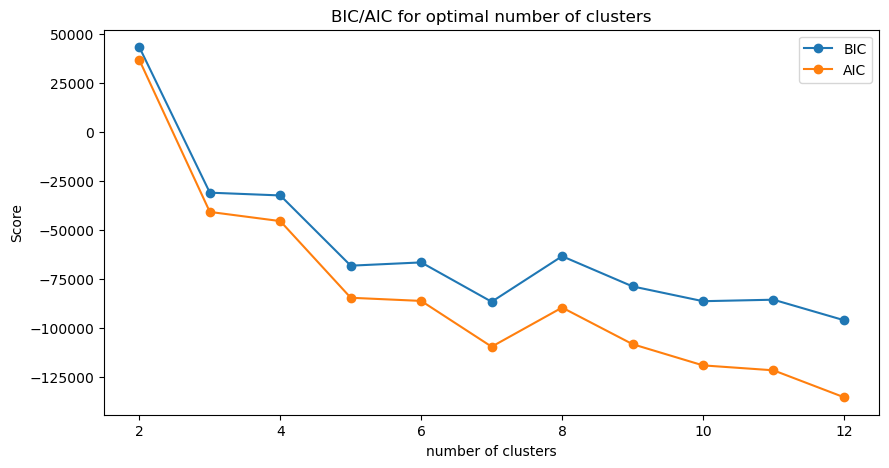

In [100]:
plt.figure(figsize=(10, 5))
plt.plot(n_components_range, bics, label='BIC', marker='o')
plt.plot(n_components_range, aics, label='AIC', marker='o')
plt.xlabel("number of clusters")
plt.ylabel("Score")
plt.title("BIC/AIC for optimal number of clusters")
plt.legend()
plt.savefig("bic_man_gen.png", dpi=300, bbox_inches="tight")
plt.show()

In [101]:
from sklearn.metrics import silhouette_score

### calculate silhouette score for GMM with multiple number of clusters
def silhouette_for_gmm(X, k_values, covariance_type="full"):
    scores = {}

    for k in k_values:
        gmm = GaussianMixture(n_components=k, covariance_type=covariance_type, random_state=0)
        labels = gmm.fit_predict(X)

        if len(np.unique(labels)) > 1:
            score = silhouette_score(X, labels)
        else:
            score = -1  # silhouette-score not defined if k=1

        scores[k] = score
        print(f"k = {k}, Silhouette Score = {score:.4f}")

    return scores


k_values = range(2, 11)
scores = silhouette_for_gmm(data_final, k_values)



k = 2, Silhouette Score = 0.2951
k = 3, Silhouette Score = 0.2784
k = 4, Silhouette Score = 0.1305
k = 5, Silhouette Score = 0.1422
k = 6, Silhouette Score = 0.0936
k = 7, Silhouette Score = 0.0919
k = 8, Silhouette Score = 0.0878
k = 9, Silhouette Score = 0.0880
k = 10, Silhouette Score = 0.1081


## --- Model Training ---

In [102]:
gmm = GaussianMixture(n_components=3, random_state=42)
gmm.fit(data_final)

# Cluster-Zuordnung
clusters = gmm.predict(data_final)
data_final['cluster'] = clusters

In [103]:
### show all features
for col in data_final.columns:
    print(f"{col} | {data_final[col].min():.2f} --- {data_final[col].max():.2f}")

Is your employer primarily a tech company/organization?_1.0 | -1.86 --- 0.54
Have you heard of or observed negative consequences for co-workers who have been open about mental health issues in your workplace?_Yes | -0.30 --- 3.30
What is your gender?_Man | -3.69 --- 0.27
What is your gender?_Other | -0.16 --- 6.27
What is your gender?_Woman | -0.21 --- 4.68
What country do you work in?_Australia | -0.15 --- 6.55
What country do you work in?_Brazil | -0.09 --- 10.54
What country do you work in?_Canada | -0.24 --- 4.16
What country do you work in?_France | -0.09 --- 10.54
What country do you work in?_Germany | -0.19 --- 5.28
What country do you work in?_Ireland | -0.10 --- 9.99
What country do you work in?_Netherlands | -0.16 --- 6.27
What country do you work in?_Other | -0.28 --- 3.53
What country do you work in?_Sweden | -0.12 --- 8.43
What country do you work in?_United Kingdom | -0.36 --- 2.76
What country do you work in?_United States of America | -1.31 --- 0.76
Which of the followi

## --- Analyzing ---

In [104]:
### number of people in each cluster
data_final["cluster"].value_counts()

cluster
1    898
0    102
2      9
Name: count, dtype: int64

In [105]:
### first values for each new generated feature
data_final[['employer_support_score', 'prev_employer_support_score', 'openness_score', 'perceived_stigma_score', 'mh_status_score', 'cluster']].head()

,employer_support_score,prev_employer_support_score,openness_score,perceived_stigma_score,mh_status_score,cluster
0,0.322378,0.197022,0.387712,0.520357,0.227227,1
1,1.623767,1.455533,-0.323465,1.101573,-1.189836,1
2,-0.552173,-0.377400,2.422393,0.115964,1.213195,1
3,-1.823571,-0.628741,-0.323465,-0.246826,-1.189836,1
4,-1.099328,-1.526087,1.179739,-0.246826,0.426740,1


In [106]:
### mean of each new generated feature grouped by cluster (NOT STANDARDIZED!)
data_final.groupby('cluster')['employer_support_score'].mean()

cluster
0    0.056546
1    0.004451
2   -1.085011
Name: employer_support_score, dtype: float64

In [107]:
data_final.groupby('cluster')['prev_employer_support_score'].mean()

cluster
0   -0.282070
1    0.040649
2   -0.859030
Name: prev_employer_support_score, dtype: float64

In [108]:
data_final.groupby('cluster')['openness_score'].mean()

cluster
0   -0.082636
1    0.003496
2    0.587746
Name: openness_score, dtype: float64

In [109]:
data_final.groupby('cluster')['perceived_stigma_score'].mean()

cluster
0   -0.028013
1    0.002371
2    0.080932
Name: perceived_stigma_score, dtype: float64

In [110]:
data_final.groupby('cluster')['mh_status_score'].mean()

cluster
0   -0.474055
1    0.051882
2    0.195974
Name: mh_status_score, dtype: float64

In [111]:
import seaborn as sns

# 1. get mean of each feature grouped by cluster
cluster_means = data_final.groupby("cluster").mean()

# 2. standardize all values to easily compare them
cluster_means_std = (cluster_means - cluster_means.mean()) / cluster_means.std()

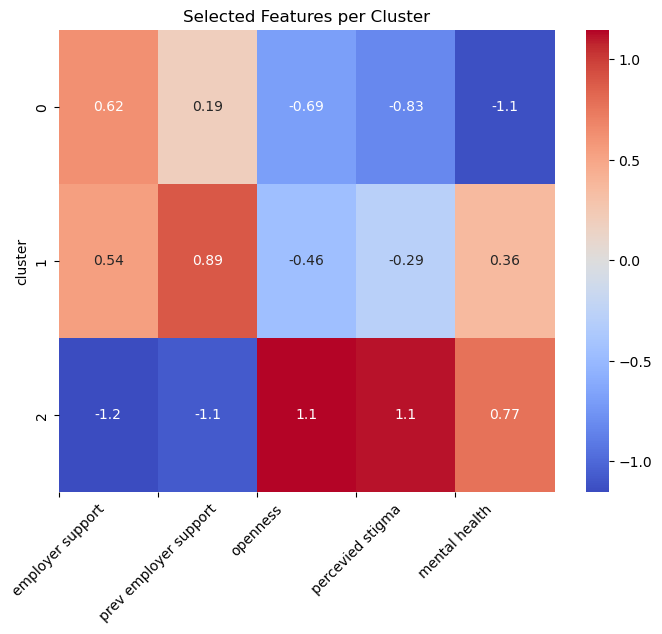

In [112]:
# only show new generated features
features = [
    "employer_support_score",
    "prev_employer_support_score",
    "openness_score",
    "perceived_stigma_score",
    "mh_status_score",
]

plt.figure(figsize=(8, 6))
sns.heatmap(cluster_means_std[features], cmap="coolwarm", center=0, annot=True)
plt.title("Selected Features per Cluster")
plt.savefig("selected_features_per_cluster.png", dpi=300, bbox_inches="tight")
new_labels = ["employer support", "prev employer support", "openness", "percevied stigma", "mental health"]
plt.xticks(rotation=45, labels = new_labels, ticks=range(len(new_labels)))
plt.show()

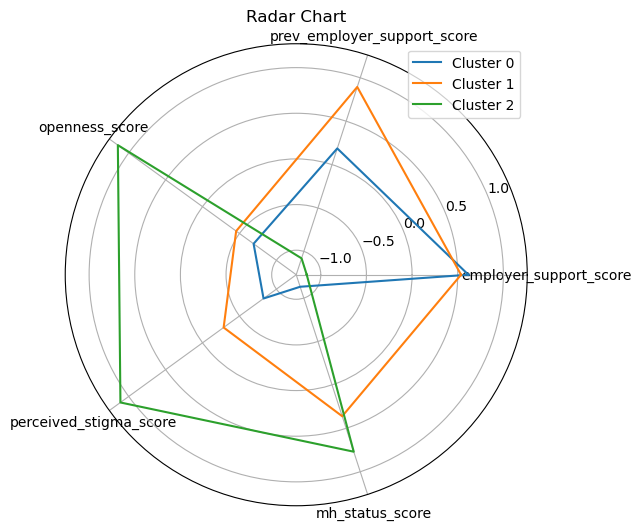

In [130]:
### radar chart for the same values as above
scores = ["employer_support_score", "prev_employer_support_score",
          "openness_score", "perceived_stigma_score", "mh_status_score"]

cluster_means = cluster_means_std[scores]

angles = np.linspace(0, 2*np.pi, len(scores), endpoint=False).tolist()
angles += angles[:1]

plt.figure(figsize=(6,6))

for cluster in cluster_means.index:
    values = cluster_means.loc[cluster].tolist()
    values += values[:1]
    plt.polar(angles, values, label=f"Cluster {cluster}")

plt.xticks(angles[:-1], scores)
plt.legend()
plt.title("Radar Chart")
plt.savefig("selected_features_radar_chart.png", dpi=300, bbox_inches="tight")
plt.show()

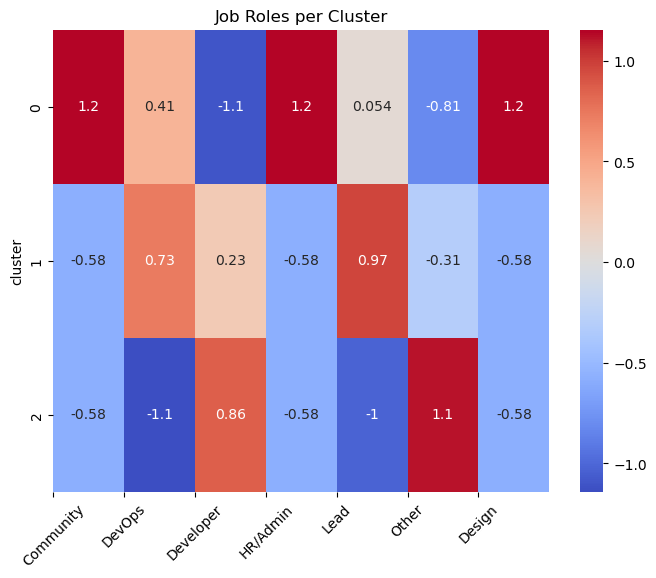

In [131]:
### job roles across all clusters
features = [
    "Which of the following best describes your work position?_Community",
    "Which of the following best describes your work position?_DevOps",
    "Which of the following best describes your work position?_Developer",
    "Which of the following best describes your work position?_HR / Admin",
    "Which of the following best describes your work position?_Management / Lead",
    "Which of the following best describes your work position?_Other",
    "Which of the following best describes your work position?_Product Design"
]

plt.figure(figsize=(8, 6))
sns.heatmap(cluster_means_std[features], cmap="coolwarm", center=0, annot=True)
plt.title("Job Roles per Cluster")
new_labels = ["Community", "DevOps", "Developer", "HR/Admin", "Lead", "Other", "Design"]
plt.xticks(ticks=range(len(new_labels)), labels=new_labels, rotation=45)
plt.savefig("job_roles_per_cluster.png", dpi=300, bbox_inches="tight")
plt.show()

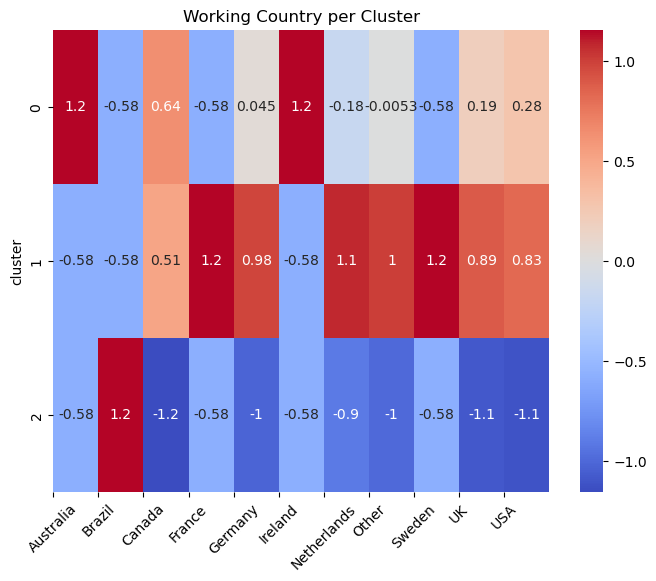

In [132]:
### working country across all clusters
features = [
    "What country do you work in?_Australia",
    "What country do you work in?_Brazil",
    "What country do you work in?_Canada",
    "What country do you work in?_France",
    "What country do you work in?_Germany",
    "What country do you work in?_Ireland",
    "What country do you work in?_Netherlands",
    "What country do you work in?_Other",
    "What country do you work in?_Sweden",
    "What country do you work in?_United Kingdom",
    "What country do you work in?_United States of America"
]

plt.figure(figsize=(8, 6))
sns.heatmap(cluster_means_std[features], cmap="coolwarm", center=0, annot=True)
plt.title("Working Country per Cluster")
new_labels = ["Australia", "Brazil", "Canada", "France", "Germany", "Ireland", "Netherlands", "Other", "Sweden", "UK", "USA"]
plt.xticks(ticks=range(len(new_labels)), labels=new_labels, rotation=45)
plt.savefig("working_country_per_cluster.png", dpi=300, bbox_inches="tight")
plt.show()

(array([0, 1, 2]), [Text(0, 0, '0'), Text(1, 0, '1'), Text(2, 0, '2')])

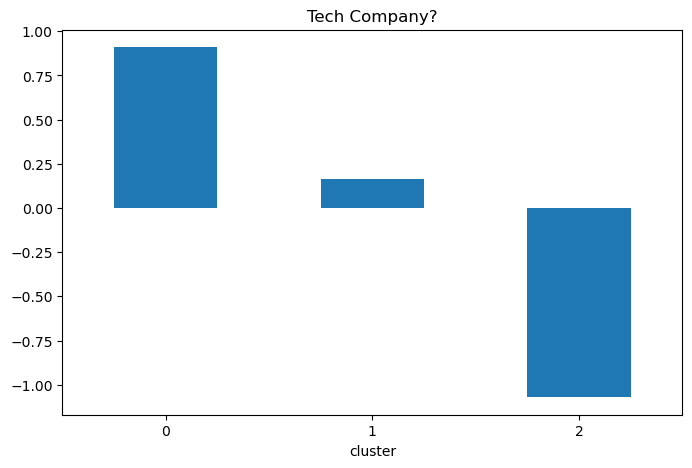

In [133]:
### tech company?
fig, ax = plt.subplots(figsize=(8,5))
ax.grid(axis='y', linestyle='--', alpha=0.7)
cluster_means_std["Is your employer primarily a tech company/organization?_1.0"].plot(kind="bar")
plt.title("Tech Company?")
plt.xticks(rotation=0)

(array([0, 1, 2]), [Text(0, 0, '0'), Text(1, 0, '1'), Text(2, 0, '2')])

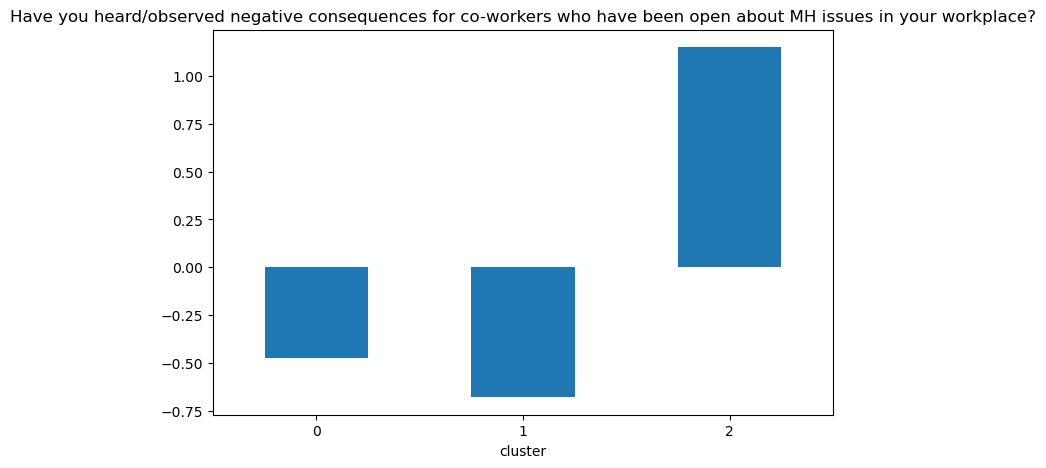

In [134]:
### negatives consequences?
fig, ax = plt.subplots(figsize=(8,5))
ax.grid(axis='y', linestyle='--', alpha=0.7)
cluster_means_std["Have you heard of or observed negative consequences for co-workers who have been open about mental health issues in your workplace?_Yes"].plot(kind="bar")
plt.title("Have you heard/observed negative consequences for co-workers who have been open about MH issues in your workplace?")
plt.xticks(rotation=0)

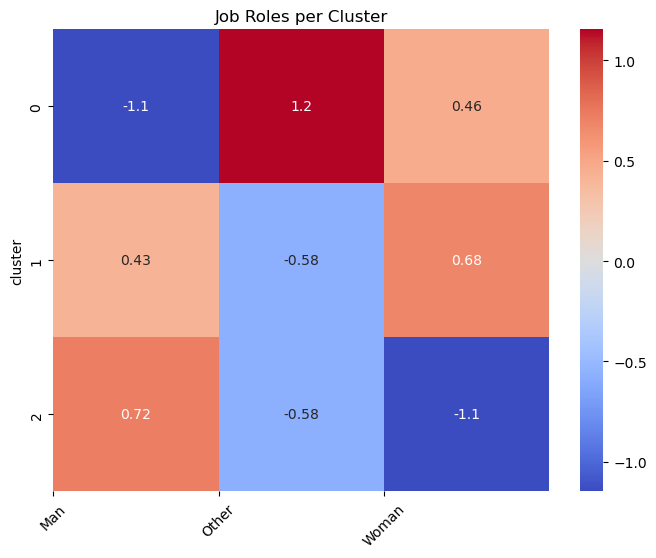

In [135]:
### job roles across all clusters
features = [
    "What is your gender?_Man",
    "What is your gender?_Other",
    "What is your gender?_Woman"
]

plt.figure(figsize=(8, 6))
sns.heatmap(cluster_means_std[features], cmap="coolwarm", center=0, annot=True)
plt.title("Job Roles per Cluster")
new_labels = ["Man", "Other", "Woman"]
plt.xticks(ticks=range(len(new_labels)), labels=new_labels, rotation=45)
plt.savefig("gender_per_cluster.png", dpi=300, bbox_inches="tight")
plt.show()

(array([0, 1, 2]), [Text(0, 0, '0'), Text(1, 0, '1'), Text(2, 0, '2')])

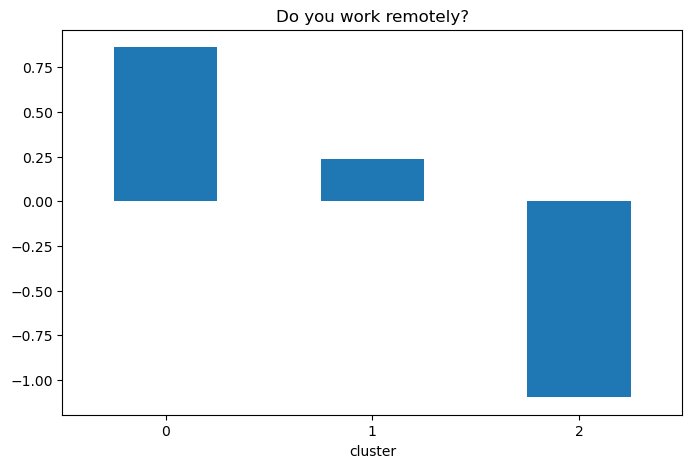

In [136]:
### remote work?
fig, ax = plt.subplots(figsize=(8,5))
ax.grid(axis='y', linestyle='--', alpha=0.7)
cluster_means_std["Do you work remotely?"].plot(kind="bar")
plt.title("Do you work remotely?")
plt.xticks(rotation=0)

In [137]:
import joblib
# import previously used scaler and encoder
scaler = joblib.load("scaler.pkl")
encoder = joblib.load('ordinal_encoder.pkl')

# first 'delete' cluster column so there are only 35 as before, when scaling
df_no_cluster = data_final.drop(columns=["cluster"])

# unscale
data_unscaled = scaler.inverse_transform(df_no_cluster)
# transform to DataFrame
df_unscaled = pd.DataFrame(data_unscaled, columns=df_no_cluster.columns)

# keep only the 7 columns to encode
cols_to_keep = [
    "How many employees does your company or organization have?",
    "If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:",
    "How willing would you be to share with friends and family that you have a mental illness?",
    "If you have a mental health issue, do you feel that it interferes with your work when being treated effectively?",
    "If you have a mental health issue, do you feel that it interferes with your work when NOT being treated effectively?",
    "What is your age?",
    "Do you work remotely?",
]
data_filtered = df_unscaled[cols_to_keep].copy()

# decode
data_decoded = encoder.inverse_transform(data_filtered)
# transform to DataFrame
df_decoded = pd.DataFrame(data_decoded, columns=data_filtered.columns)


# put decoded values back in the unscaled df
df_unscaled[cols_to_keep] = df_decoded[cols_to_keep]

# bring back 'cluster' column
df_unscaled["cluster"] = data_final["cluster"].values

print("Ursprüngliche kategorische Werte:")
print(df_decoded.head())
print("---------------------------------------------------------------------------------------------------------------------------------------------------------")
print(df_unscaled)

Ursprüngliche kategorische Werte:
  How many employees does your company or organization have?  \
0                                                1-5           
1                                     More than 1000           
2                                     More than 1000           
3                                     More than 1000           
4                                               6-25           

  If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:  \
0                                     Very difficult                                                            
1                                     Very difficult                                                            
2                                     Very difficult                                                            
3                                     Very difficult                                                            
4               

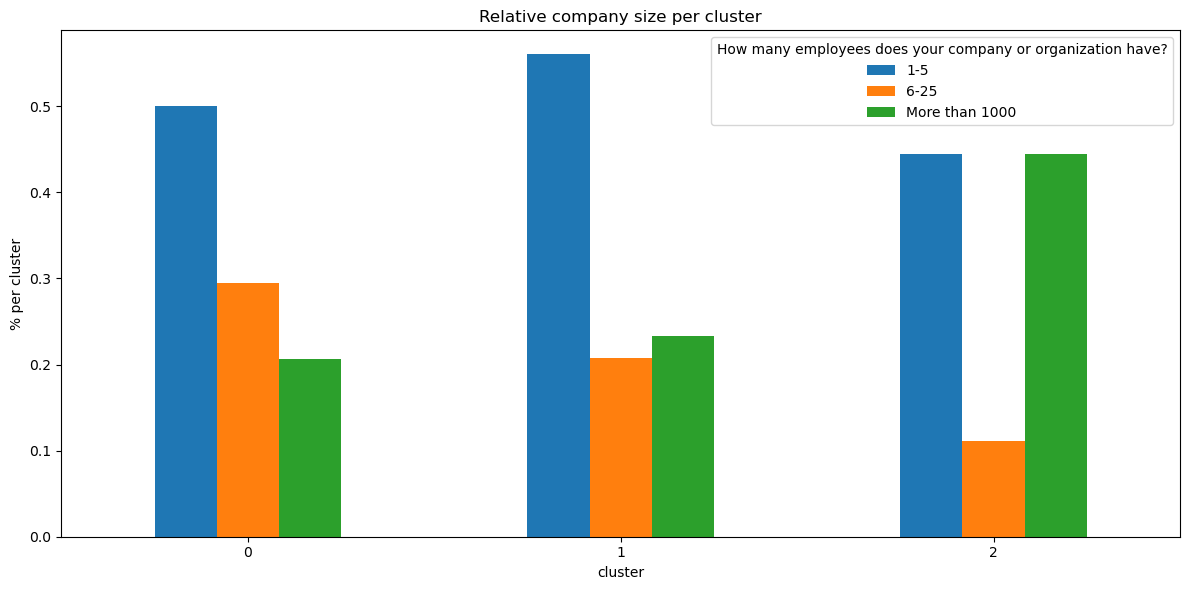

In [138]:
### How many employees in the company?
counts = df_unscaled.groupby(
    ["cluster", "How many employees does your company or organization have?"]
).size().reset_index(name="count")

pivot = counts.pivot(
    index="cluster",
    columns="How many employees does your company or organization have?",
    values="count"
)

# standardize the values (sum of each cluster = 1)
pivot_ratio = pivot.div(pivot.sum(axis=1), axis=0)

pivot_ratio.plot(kind="bar", figsize=(12,6))
plt.ylabel("% per cluster")
plt.title("Relative company size per cluster")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("relative_company_size.png", dpi=300, bbox_inches="tight")
plt.show()

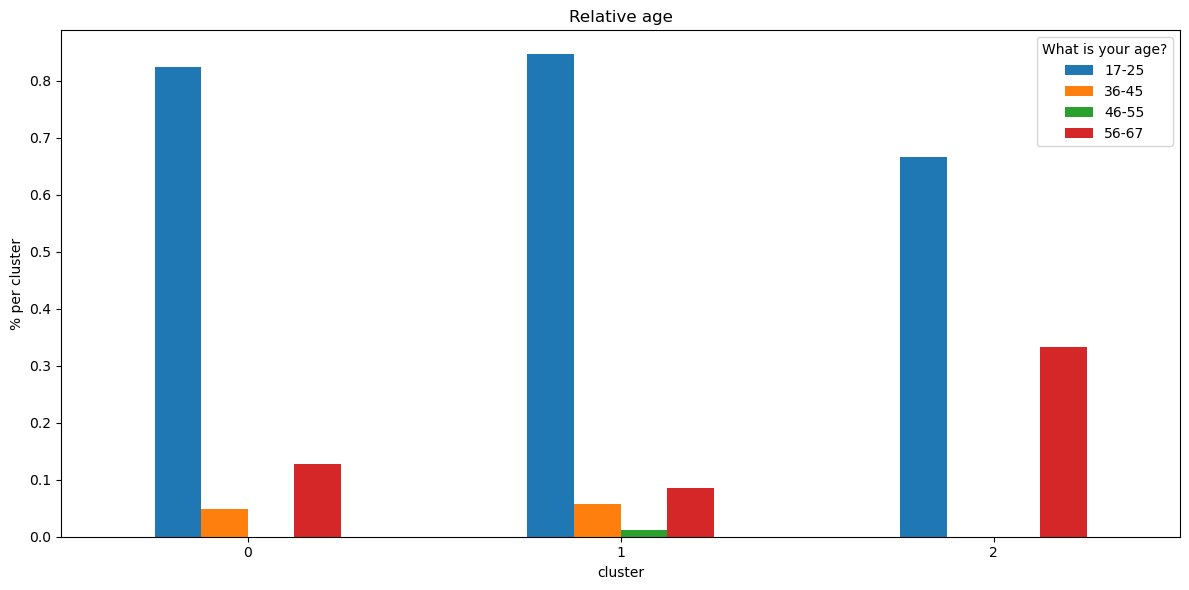

In [139]:
### Age
counts = df_unscaled.groupby(
    ["cluster", "What is your age?"]
).size().reset_index(name="count")

pivot = counts.pivot(
    index="cluster",
    columns="What is your age?",
    values="count"
)

# standardize the values (sum of each cluster = 1)
pivot_ratio = pivot.div(pivot.sum(axis=1), axis=0)

pivot_ratio.plot(kind="bar", figsize=(12,6))
plt.ylabel("% per cluster")
plt.title("Relative age")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("relative_age.png", dpi=300, bbox_inches="tight")
plt.show()

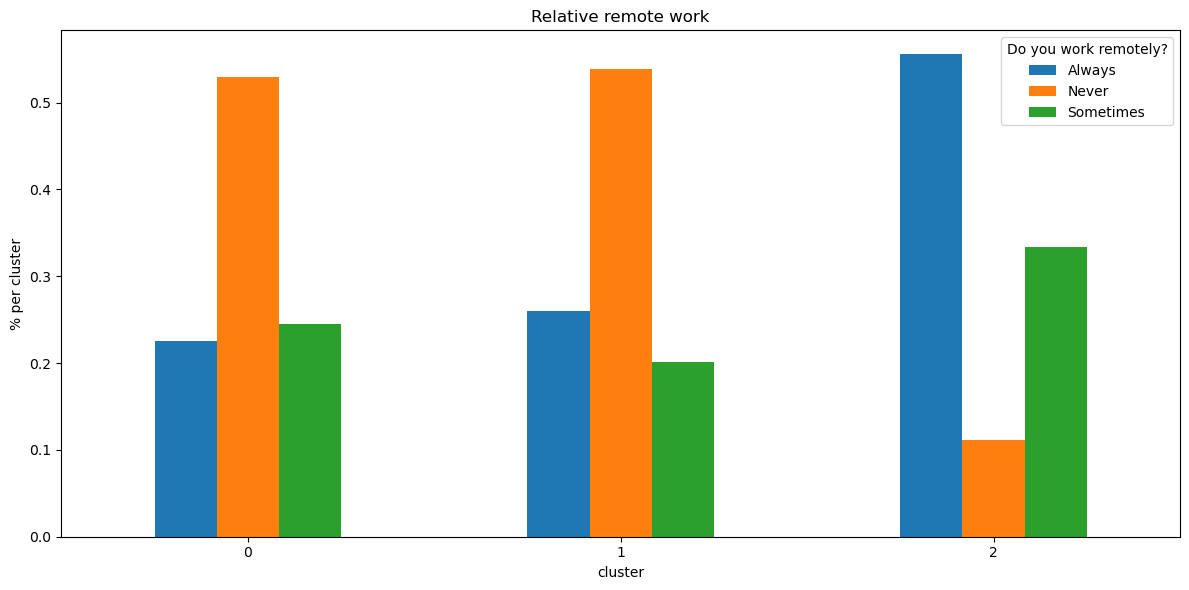

In [140]:
### Remote Work?
counts = df_unscaled.groupby(
    ["cluster", "Do you work remotely?"]
).size().reset_index(name="count")

pivot = counts.pivot(
    index="cluster",
    columns="Do you work remotely?",
    values="count"
)

# standardize the values (sum of each cluster = 1)
pivot_ratio = pivot.div(pivot.sum(axis=1), axis=0)

pivot_ratio.plot(kind="bar", figsize=(12,6))
plt.ylabel("% per cluster")
plt.title("Relative remote work")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("relative_remote_work.png", dpi=300, bbox_inches="tight")
plt.show()

In [141]:
# - 
# - How willing would you be to share with friends and family that you have a mental illness?
# - If you have a mental health issue, do you feel that it interferes with your work when being treated effectively?
# - If you have a mental health issue, do you feel that it interferes with your work when NOT being treated effectively?

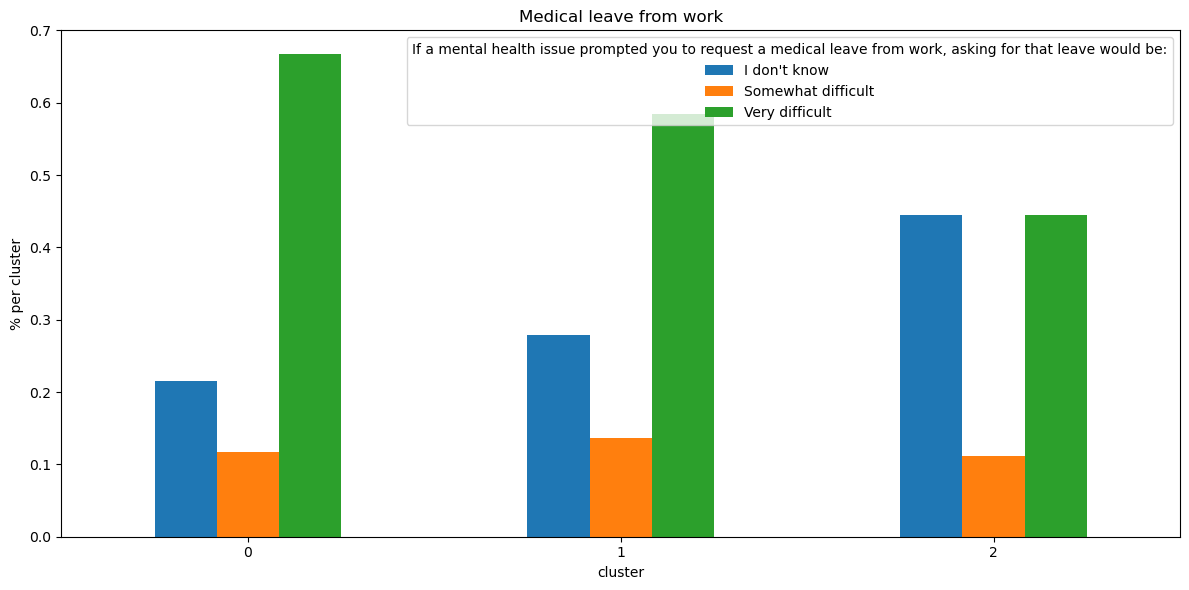

In [142]:
### If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:
counts = df_unscaled.groupby(
    ["cluster", "If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:"]
).size().reset_index(name="count")

pivot = counts.pivot(
    index="cluster",
    columns="If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:",
    values="count"
)

# standardize the values (sum of each cluster = 1)
pivot_ratio = pivot.div(pivot.sum(axis=1), axis=0)

pivot_ratio.plot(kind="bar", figsize=(12,6))
plt.ylabel("% per cluster")
plt.title("Medical leave from work")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("medical_leave_from_work.png", dpi=300, bbox_inches="tight")
plt.show()

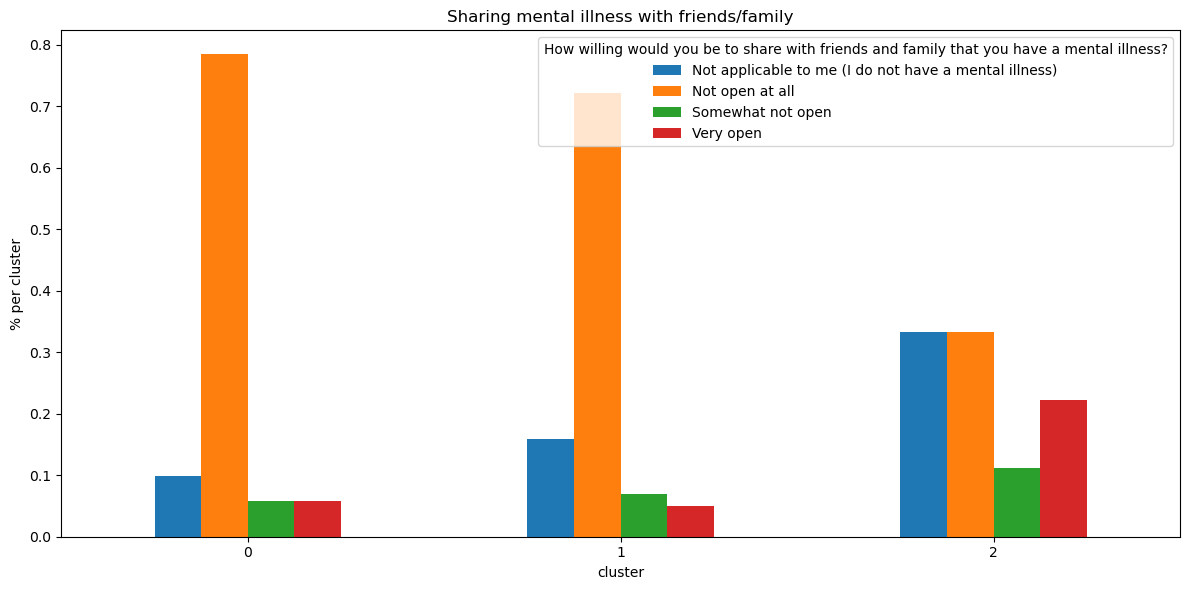

In [143]:
### How willing would you be to share with friends and family that you have a mental illness?
counts = df_unscaled.groupby(
    ["cluster", "How willing would you be to share with friends and family that you have a mental illness?"]
).size().reset_index(name="count")

pivot = counts.pivot(
    index="cluster",
    columns="How willing would you be to share with friends and family that you have a mental illness?",
    values="count"
)

# standardize the values (sum of each cluster = 1)
pivot_ratio = pivot.div(pivot.sum(axis=1), axis=0)

pivot_ratio.plot(kind="bar", figsize=(12,6))
plt.ylabel("% per cluster")
plt.title("Sharing mental illness with friends/family")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("sharing_mental_illness.png", dpi=300, bbox_inches="tight")
plt.show()

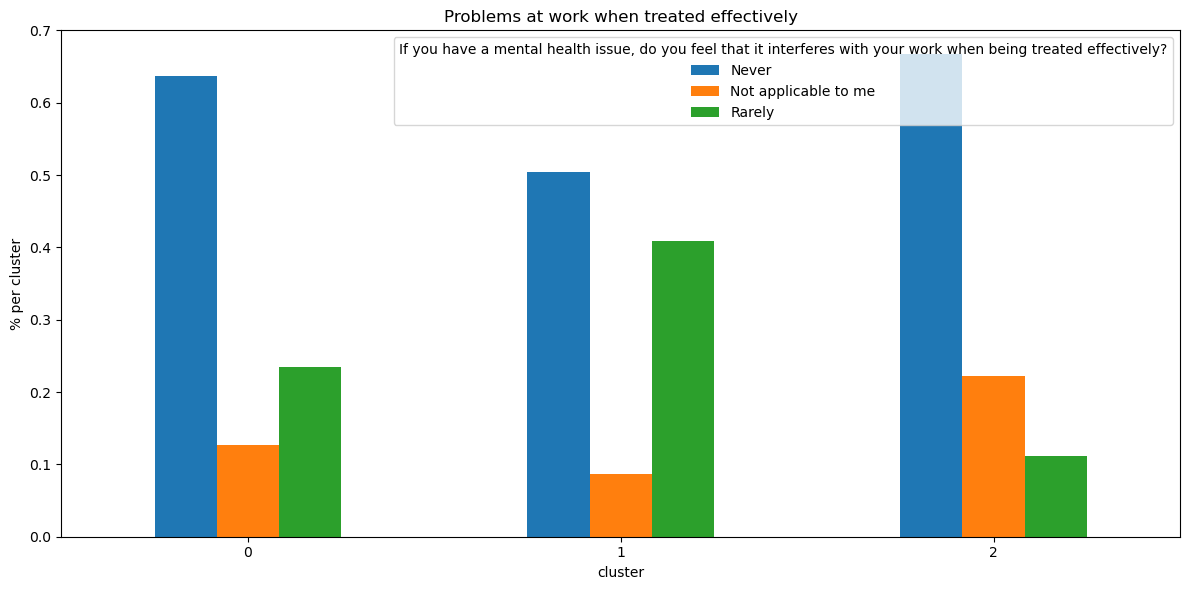

In [144]:
### If you have a mental health issue, do you feel that it interferes with your work when being treated effectively?
counts = df_unscaled.groupby(
    ["cluster", "If you have a mental health issue, do you feel that it interferes with your work when being treated effectively?"]
).size().reset_index(name="count")

pivot = counts.pivot(
    index="cluster",
    columns="If you have a mental health issue, do you feel that it interferes with your work when being treated effectively?",
    values="count"
)

# standardize the values (sum of each cluster = 1)
pivot_ratio = pivot.div(pivot.sum(axis=1), axis=0)

pivot_ratio.plot(kind="bar", figsize=(12,6))
plt.ylabel("% per cluster")
plt.title("Problems at work when treated effectively")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("problems_at_work_treated_effectively.png", dpi=300, bbox_inches="tight")
plt.show()

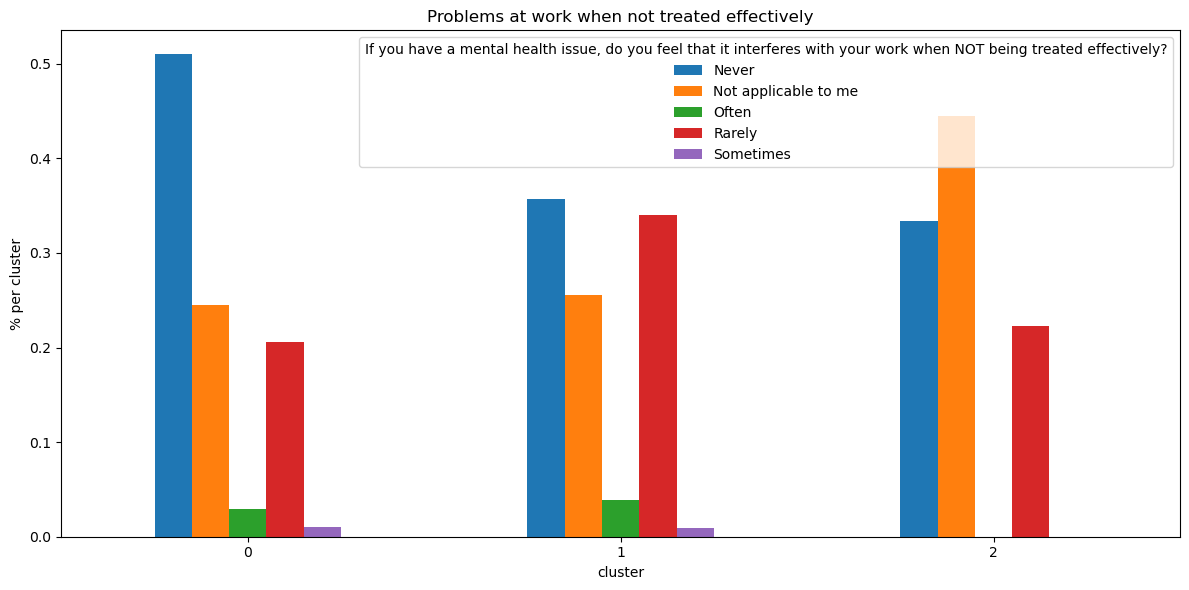

In [145]:
### IIf you have a mental health issue, do you feel that it interferes with your work when NOT being treated effectively?
counts = df_unscaled.groupby(
    ["cluster", "If you have a mental health issue, do you feel that it interferes with your work when NOT being treated effectively?"]
).size().reset_index(name="count")

pivot = counts.pivot(
    index="cluster",
    columns="If you have a mental health issue, do you feel that it interferes with your work when NOT being treated effectively?",
    values="count"
)

# standardize the values (sum of each cluster = 1)
pivot_ratio = pivot.div(pivot.sum(axis=1), axis=0)

pivot_ratio.plot(kind="bar", figsize=(12,6))
plt.ylabel("% per cluster")
plt.title("Problems at work when not treated effectively")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("problems_at_work_not_treated_effectively.png", dpi=300, bbox_inches="tight")
plt.show()